# Notebook 2: EDA y Preparación de Datos

Preparación de dataset para backtesting de estrategia Momentum con control explícito de look-ahead bias y sesgo de supervivencia.

## 1. Configuración y Carga de Datos

### 1.1. Justificación de Estructura de Datos

Este notebook prepara los datos para backtesting de momentum con un universo dinámico. Las decisiones clave son:

- **Universo dinámico**: Se mantienen todos los tickers del dataset, incluso aquellos que empiezan a cotizar después de `history_start`. Esto permite que nuevos activos se vuelvan elegibles cuando acumulen suficiente histórico, mitigando parcialmente el sesgo de supervivencia.

- **DataFrames wide separados**: Se construyen `prices_close_wide` y `prices_open_wide` por separado porque el motor de backtesting necesita ambos precios para ejecutar órdenes (compra en CLOSE, venta en OPEN).

- **Histórico desde history_start**: Se necesita histórico desde 13 meses antes de `BACKTEST_START_DATE` para calcular momentum con lag de 1 mes, requiriendo precios en t-13, t-7 y t-1.

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

BACKTEST_START_DATE = '2015-01-01'
MIN_MONTHS_HISTORY = 13
FFILL_GAP_LIMIT_DAYS = 5

DATA_RAW_DIR = '../datos/raw'
DATA_PROCESSED_DIR = '../datos/processed'

TICKERS_PARQUET = f'{DATA_RAW_DIR}/tickers_data.parquet'
SPY_PARQUET = f'{DATA_RAW_DIR}/spy_data.parquet'

tickers_df = pd.read_parquet(TICKERS_PARQUET)
if not isinstance(tickers_df.index, pd.DatetimeIndex):
    if 'date' in tickers_df.columns:
        tickers_df['date'] = pd.to_datetime(tickers_df['date'])
        tickers_df = tickers_df.set_index('date')
    else:
        raise ValueError("No se encuentra indice datetime ni columna 'date'.")
tickers_df = tickers_df.sort_index()

required_cols = {'symbol', 'close', 'open'}
if required_cols - set(tickers_df.columns):
    raise ValueError(f'Faltan columnas: {sorted(required_cols - set(tickers_df.columns))}')

spy_df = pd.read_parquet(SPY_PARQUET)
if not isinstance(spy_df.index, pd.DatetimeIndex) and 'date' in spy_df.columns:
    spy_df['date'] = pd.to_datetime(spy_df['date'])
    spy_df = spy_df.set_index('date').sort_index()

if spy_df.index.tz is not None:
    spy_df.index = spy_df.index.tz_localize(None)

prices_close_wide = tickers_df.pivot_table(
    index=tickers_df.index,
    columns='symbol',
    values='close'
).sort_index()

prices_open_wide = tickers_df.pivot_table(
    index=tickers_df.index,
    columns='symbol',
    values='open'
).sort_index()

assert prices_open_wide.shape == prices_close_wide.shape
assert (prices_open_wide.index == prices_close_wide.index).all()
assert (prices_open_wide.columns == prices_close_wide.columns).all()

print(f'Precios wide: {prices_close_wide.shape}')
print(f'Rango: {prices_close_wide.index.min().date()} a {prices_close_wide.index.max().date()}')

Precios wide: (9087, 1289)
Rango: 1990-01-02 a 2026-01-30


## 2. Análisis de Fechas y Diagnóstico de Entradas Tardías

### 2.1. Universo Dinámico y Sesgo de Supervivencia

El sesgo de supervivencia ocurre cuando solo se consideran activos que sobreviven hasta el final del período de análisis, excluyendo aquellos que fueron delisted durante el período. Esto puede inflar artificialmente los retornos porque se ignoran los activos que tuvieron mal desempeño y fueron eliminados del índice.

En este backtesting, NO eliminamos tickers que empiezan después de `history_start` porque:

1. **Universo dinámico**: Permite que nuevos activos se vuelvan elegibles cuando acumulen suficiente histórico (13 meses), reflejando mejor la realidad operativa.

2. **Mitigación parcial del sesgo**: Al mantener todos los tickers y evaluar elegibilidad por fecha, capturamos parcialmente el efecto de activos que entran y salen del universo.

**Limitaciones**: Aún existe sesgo de supervivencia porque solo consideramos tickers que sobreviven hasta el final del dataset. Sin datos históricos de delistings, no podemos eliminar completamente este sesgo.

In [ ]:
import matplotlib.dates as mdates



Fechas criticas:
  data_start: 1990-01-02
  history_start: 2013-12-01
  backtest_start: 2015-01-01
  data_end: 2026-01-30

Tickers con datos: 1289


### 2.2. Calculo de Fechas Criticas

Calculo optimizado de fechas criticas usando operaciones vectorizadas.

In [ ]:
backtest_start = pd.to_datetime(BACKTEST_START_DATE)
if backtest_start.tz is not None:
    backtest_start = backtest_start.tz_localize(None)
history_start = backtest_start - pd.DateOffset(months=MIN_MONTHS_HISTORY)
data_start = prices_close_wide.index.min()
data_end = prices_close_wide.index.max()

first_date = prices_close_wide.apply(pd.Series.first_valid_index)
last_date = prices_close_wide.apply(pd.Series.last_valid_index)
dates_df = pd.DataFrame({
    'first_date': first_date,
    'last_date': last_date
})

print(f'Fechas criticas:')
print(f'  data_start: {data_start.date()}')
print(f'  history_start: {history_start.date()}')
print(f'  backtest_start: {backtest_start.date()}')
print(f'  data_end: {data_end.date()}')
print(f'\nTickers con datos: {dates_df["first_date"].notna().sum()}')

### 2.3. Visualizaciones Diagnosticas

In [ ]:
valid_first = dates_df['first_date'].dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(valid_first, bins=60, color='steelblue', alpha=0.75, edgecolor='black')
ax.axvline(history_start, color='green', linestyle='--', linewidth=2,
           label=f'history_start ({history_start.date()})')
ax.axvline(backtest_start, color='red', linestyle='--', linewidth=2,
           label=f'BACKTEST_START_DATE ({backtest_start.date()})')
ax.set_title('Distribucion de first_date por ticker', fontweight='bold')
ax.set_xlabel('Fecha (first_date)')
ax.set_ylabel('Numero de tickers')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

first_by_month = valid_first.to_frame('first_date')
first_by_month['year_month'] = first_by_month['first_date'].dt.to_period('M')
monthly_starts = first_by_month.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_starts.index.to_timestamp(), monthly_starts.values,
        color='steelblue', linewidth=2, marker='o', markersize=3)
ax.axvline(history_start, color='green', linestyle='--', linewidth=2,
           label=f'history_start ({history_start.date()})')
ax.axvline(backtest_start, color='red', linestyle='--', linewidth=2,
           label=f'BACKTEST_START_DATE ({backtest_start.date()})')
ax.set_title('Timeline de numero de tickers que empiezan por mes',
             fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Numero de tickers')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

available_by_date = prices_close_wide.notna().sum(axis=1)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(available_by_date.index, available_by_date.values,
        color='darkgreen', linewidth=1.5)
ax.axvline(history_start, color='green', linestyle='--', linewidth=2,
           label=f'history_start ({history_start.date()})')
ax.axvline(backtest_start, color='red', linestyle='--', linewidth=2,
           label=f'BACKTEST_START_DATE ({backtest_start.date()})')
ax.set_title('Timeline de numero de tickers disponibles por mes',
             fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Tickers disponibles')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

lifespan = (dates_df['last_date'] - dates_df['first_date']).dt.days
lifespan_valid = lifespan.dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(lifespan_valid, bins=60, color='steelblue', alpha=0.75, edgecolor='black')
ax.set_title('Distribucion de duracion de vida de tickers (dias)',
             fontweight='bold')
ax.set_xlabel('Duracion (dias)')
ax.set_ylabel('Numero de tickers')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Validacion de Integridad OPEN/CLOSE

### 3.1. Importancia de OPEN/CLOSE para Ejecucion

Los precios OPEN y CLOSE son criticos para el motor de backtesting porque:

- **Reglas de ejecucion**: Las ordenes se ejecutan en CLOSE del dia de rebalanceo (compra) y en OPEN del dia siguiente (venta). Sin estos precios, el motor no puede simular correctamente las transacciones.

- **Validaciones necesarias**: Se verifica que OPEN y CLOSE esten disponibles en todas las fechas de rebalanceo. Si faltan, la simulacion no puede proceder correctamente.

**Nota**: No se valida que OPEN > CLOSE porque no es una anomalia - es normal que el precio de apertura sea mayor o menor que el de cierre del dia anterior.

Calidad (dentro de vida):
count   1289.000000
mean       0.221390
std        2.709260
min        0.000000
50%        0.000000
75%        0.000000
90%        0.076036
95%        0.278332
max       65.659955
Name: pct_missing_within_life, dtype: float64


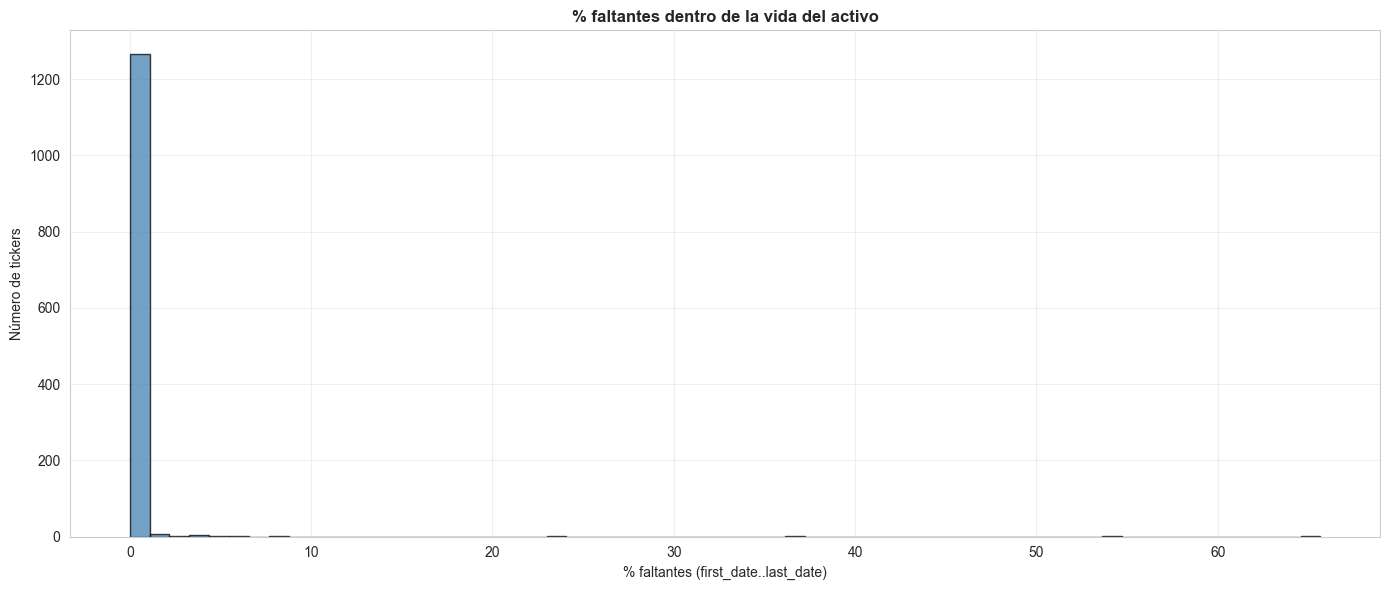

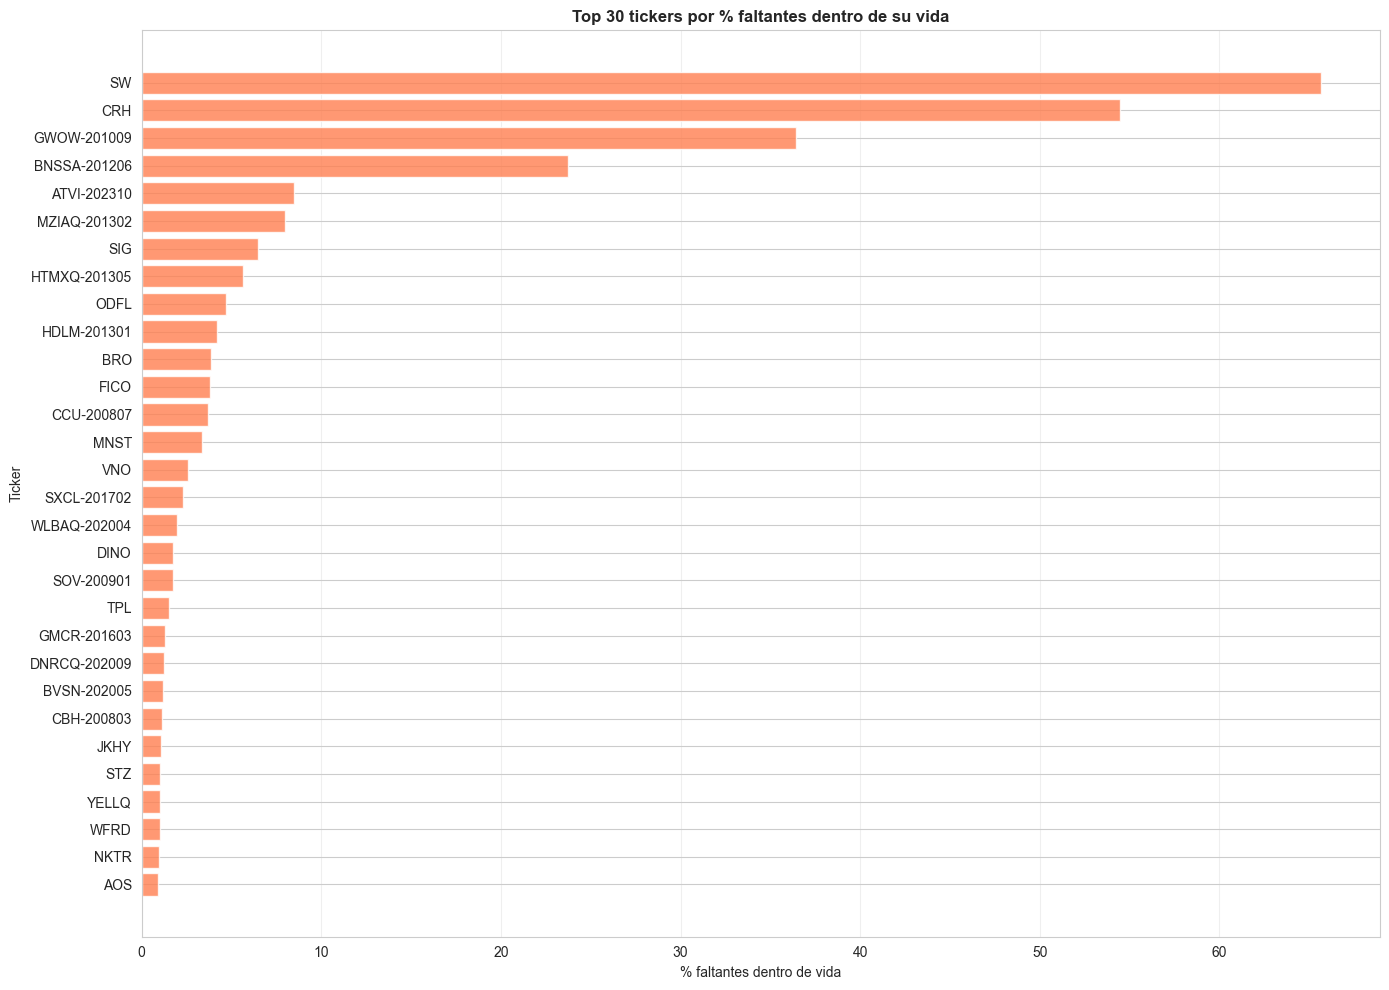

In [ ]:
def compute_availability_within_life(prices: pd.DataFrame,
                                      first: pd.Series,
                                      last: pd.Series) -> pd.Series:
    """Compute percent available within each asset's life (vectorized).

    Parameters
    ----------
    prices : pd.DataFrame
        Wide prices with DatetimeIndex and tickers as columns.
    first : pd.Series
        First valid date per ticker.
    last : pd.Series
        Last valid date per ticker.

    Returns
    -------
    pd.Series
        Percent available within life per ticker.
    """
    pct_available = pd.Series(index=prices.columns, dtype='float64')

    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)

        if pd.isna(f) or pd.isna(l):
            pct_available.loc[ticker] = np.nan
            continue

        life_slice = prices.loc[f:l, ticker]
        if len(life_slice) == 0:
            pct_available.loc[ticker] = np.nan
            continue

        pct_available.loc[ticker] = life_slice.notna().mean() * 100.0

    return pct_available


open_availability = compute_availability_within_life(
    prices=prices_open_wide,
    first=dates_df['first_date'],
    last=dates_df['last_date']
)

close_availability = compute_availability_within_life(
    prices=prices_close_wide,
    first=dates_df['first_date'],
    last=dates_df['last_date']
)

availability_df = pd.DataFrame({
    'open_availability': open_availability,
    'close_availability': close_availability
})

availability_df['pct_missing_within_life'] = (
    100.0 - availability_df[['open_availability', 'close_availability']].mean(axis=1)
)

dates_df['pct_missing_within_life'] = availability_df['pct_missing_within_life']

problematic_tickers = availability_df[
    (availability_df['open_availability'] < 90) |
    (availability_df['close_availability'] < 90)
]

print(f'Tickers con disponibilidad < 90%: {len(problematic_tickers)}')
if len(problematic_tickers) > 0:
    print('\nTop 10 tickers problematicos:')
    print(problematic_tickers.nsmallest(10, 'pct_missing_within_life'))

### 3.2. Validaciones OPEN/CLOSE

### 3.3. Visualizaciones

In [ ]:
top_30_open = availability_df.nlargest(30, 'open_availability')
top_30_close = availability_df.nlargest(30, 'close_availability')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(range(len(top_30_open)), top_30_open['open_availability'].values,
             color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(top_30_open)))
axes[0].set_yticklabels(top_30_open.index)
axes[0].set_title('Top 30 tickers por disponibilidad OPEN', fontweight='bold')
axes[0].set_xlabel('Disponibilidad (%)')
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(range(len(top_30_close)), top_30_close['close_availability'].values,
             color='darkgreen', alpha=0.8)
axes[1].set_yticks(range(len(top_30_close)))
axes[1].set_yticklabels(top_30_close.index)
axes[1].set_title('Top 30 tickers por disponibilidad CLOSE', fontweight='bold')
axes[1].set_xlabel('Disponibilidad (%)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

sample_tickers = availability_df.nlargest(20, 'open_availability').index[:10]
sample_dates = prices_open_wide.index[::100]

open_sample = prices_open_wide.loc[sample_dates, sample_tickers].notna()
close_sample = prices_close_wide.loc[sample_dates, sample_tickers].notna()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

sns.heatmap(open_sample.T, ax=axes[0], cmap='RdYlGn', cbar_kws={'label': 'Disponible'},
            xticklabels=50, yticklabels=True)
axes[0].set_title('Timeline de disponibilidad OPEN (muestra de tickers)',
                  fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Ticker')

sns.heatmap(close_sample.T, ax=axes[1], cmap='RdYlGn', cbar_kws={'label': 'Disponible'},
            xticklabels=50, yticklabels=True)
axes[1].set_title('Timeline de disponibilidad CLOSE (muestra de tickers)',
                  fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Ticker')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(availability_df['open_availability'].dropna(), bins=50,
             color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribucion de completitud OPEN', fontweight='bold')
axes[0].set_xlabel('Completitud (%)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)

axes[1].hist(availability_df['close_availability'].dropna(), bins=50,
             color='darkgreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Distribucion de completitud CLOSE', fontweight='bold')
axes[1].set_xlabel('Completitud (%)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Construccion de Precios y Retornos Mensuales

### 4.1. Agregacion Mensual y Look-Ahead Bias

La agregacion mensual se realiza usando el ultimo dia habil del mes (BME - Business Month End). Esto evita look-ahead bias porque:

- **Sin informacion futura**: Solo se usa el ultimo precio disponible del mes, no se "mira hacia adelante" para usar precios de meses futuros.

- **Retornos mensuales separados**: Los retornos se calculan despues de construir los precios mensuales, asegurando que cada retorno mensual solo depende de precios de ese mes y el anterior.

- **Verificacion de lag**: El momentum se calcula con lag de 1 mes (t-1, t-7, t-13), lo que significa que en la fecha de rebalanceo t, solo usamos datos hasta t-1, nunca datos de t o posteriores.

Tickers marcados como delisted (heurística): 638


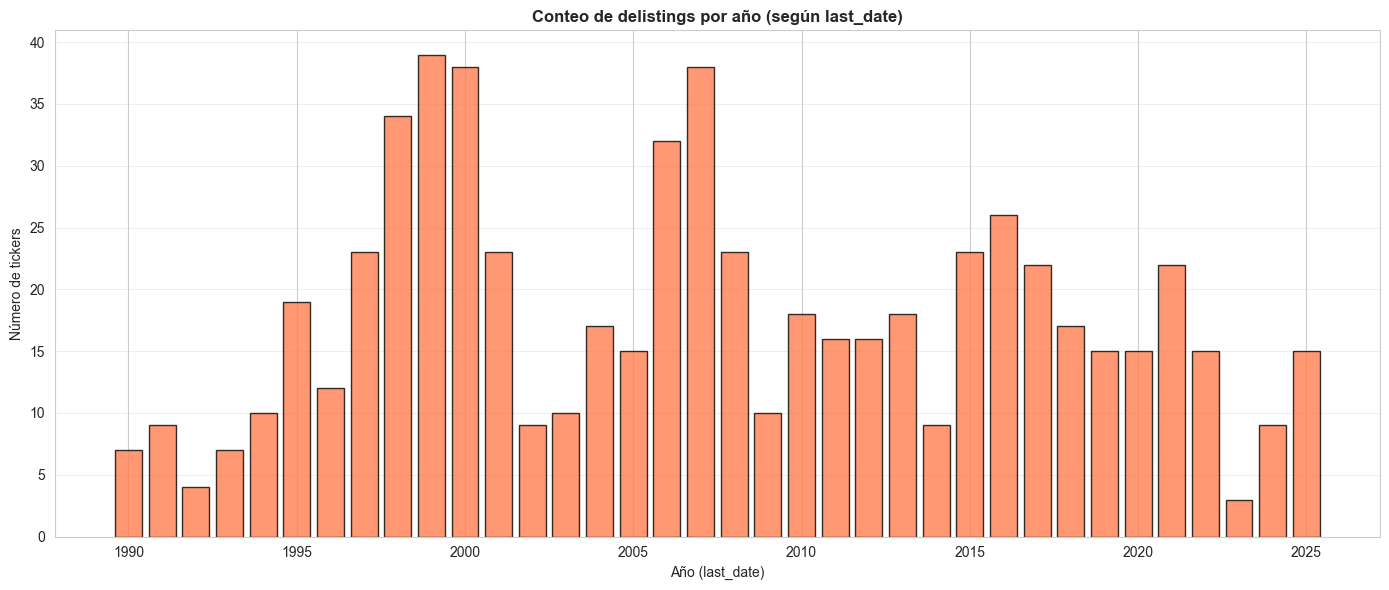


Ejemplos (top por días hasta fin del dataset):
            first_date  last_date  days_to_end  delisted
symbol                                                  
HIA-199002  1990-01-02 1990-02-07        13141      True
GNN-199006  1990-01-02 1990-06-25        13003      True
NRT-199008  1990-01-02 1990-08-08        12959      True
GRL-199008  1990-01-02 1990-08-22        12945      True
PHL-199008  1990-01-02 1990-08-22        12945      True
SOV-199008  1990-01-02 1990-08-31        12936      True
CBL-199010  1990-01-02 1990-10-08        12898      True
MCA-199101  1990-01-02 1991-01-03        12811      True
SQD-199105  1990-01-02 1991-05-28        12666      True
TKA-199108  1990-01-02 1991-08-02        12600      True
NCR-199109  1990-01-02 1991-09-19        12552      True
PN-199109   1990-01-02 1991-09-25        12546      True
CTCO-199110 1990-01-02 1991-10-31        12510      True
HBJ-199111  1990-01-02 1991-11-25        12485      True
MHC-199112  1990-01-02 1991-12-31       

In [ ]:
def calculate_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """Compute log returns from prices (daily or monthly).

    Parameters
    ----------
    prices : pd.DataFrame
        Prices (daily or monthly).

    Returns
    -------
    pd.DataFrame
        Log returns.
    """
    log_returns = np.log(prices / prices.shift(1))
    log_returns = log_returns.replace([np.inf, -np.inf], np.nan)
    return log_returns


def build_monthly_prices(prices: pd.DataFrame) -> pd.DataFrame:
    """Build business-month-end prices (generic for OPEN or CLOSE).

    Parameters
    ----------
    prices : pd.DataFrame
        Daily prices.

    Returns
    -------
    pd.DataFrame
        Monthly prices sampled at business month end.
    """
    return prices.resample('BME').last()


def calculate_log_returns_monthly(monthly_prices: pd.DataFrame) -> pd.DataFrame:
    """Calculate monthly log returns from monthly prices.

    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Monthly prices.

    Returns
    -------
    pd.DataFrame
        Monthly log returns.
    """
    return calculate_log_returns(monthly_prices)


print('Construyendo precios y retornos mensuales...')

prices_monthly_close = build_monthly_prices(prices_close_wide)
prices_monthly_open = build_monthly_prices(prices_open_wide)
log_returns_monthly = calculate_log_returns_monthly(prices_monthly_close)

print(f'Precios mensuales CLOSE: {prices_monthly_close.shape}')
print(f'Precios mensuales OPEN: {prices_monthly_open.shape}')
print(f'Retornos mensuales: {log_returns_monthly.shape}')

### 4.2. Funciones de Construccion

### 4.3. Construccion de Calendario de Rebalanceo

In [ ]:
def build_rebalance_calendar(monthly_prices: pd.DataFrame,
                             start_date: pd.Timestamp) -> pd.DatetimeIndex:
    """Build monthly rebalance calendar as last business day of each month.

    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Monthly prices (business month end).
    start_date : pd.Timestamp
        Start date for backtesting.

    Returns
    -------
    pd.DatetimeIndex
        Rebalance dates (last business day of each month >= start_date).
    """
    rebalance_dates = monthly_prices.index[monthly_prices.index >= start_date]
    return rebalance_dates


rebalance_dates = build_rebalance_calendar(prices_monthly_close, backtest_start)

print(f'Calendario de rebalanceo: {len(rebalance_dates)} fechas')
print(f'Primera fecha: {rebalance_dates[0].date()}')
print(f'Ultima fecha: {rebalance_dates[-1].date()}')

assert all(date in prices_monthly_close.index for date in rebalance_dates), \
    'Todas las fechas de rebalanceo deben estar en precios mensuales'

### 4.4. Visualizaciones

In [ ]:
sample_tickers_monthly = prices_monthly_close.columns[:5]

fig, ax = plt.subplots(figsize=(14, 6))
for ticker in sample_tickers_monthly:
    ax.plot(prices_monthly_close.index, prices_monthly_close[ticker],
            label=ticker, linewidth=1.5, alpha=0.7)
ax.set_title('Evolucion de precios mensuales (muestra de tickers)',
             fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio Mensual')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sample_returns = log_returns_monthly.iloc[:, :20].stack().dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(sample_returns, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_title('Distribucion de retornos mensuales (muestra)', fontweight='bold')
ax.set_xlabel('Retorno Logaritmico Mensual')
ax.set_ylabel('Frecuencia')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sample_ticker = sample_tickers_monthly[0]
cumulative_returns = log_returns_monthly[sample_ticker].fillna(0).cumsum()
cumulative_from_prices = np.log(prices_monthly_close[sample_ticker] /
                                prices_monthly_close[sample_ticker].iloc[0])

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(cumulative_returns, cumulative_from_prices, alpha=0.6, s=20)
ax.plot([cumulative_returns.min(), cumulative_returns.max()],
        [cumulative_returns.min(), cumulative_returns.max()],
        'r--', linewidth=2, label='y=x')
ax.set_title('Verificacion de propiedad aditiva de retornos logaritmicos',
             fontweight='bold')
ax.set_xlabel('Retornos acumulados (suma de retornos)')
ax.set_ylabel('Retornos acumulados (log(P_t/P_0))')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Construccion de Elegibilidad para Momentum

### 5.1. Elegibilidad y Control de Look-Ahead Bias

El look-ahead bias ocurre cuando se usa informacion que no estaba disponible en el momento de la decision. Para evitarlo:

- **Elegibilidad basada en datos pasados**: Un ticker es elegible en fecha t solo si tiene precios disponibles en t-13, t-7 y t-1 (nunca en t o posteriores).

- **Verificacion explicita**: Se valida que la funcion de elegibilidad solo usa datos hasta t-1, nunca datos de t o futuros.

- **Limitaciones**: Aun puede haber sesgo si los datos historicos estan mal ajustados (splits, dividendos), pero esto es una limitacion del dataset, no del proceso.

Construyendo retornos y calendario de rebalanceo...
  Precios mensuales: (433, 1289)
  Rebalanceos: 133 meses

Elegibilidad: 651-767 tickers por mes


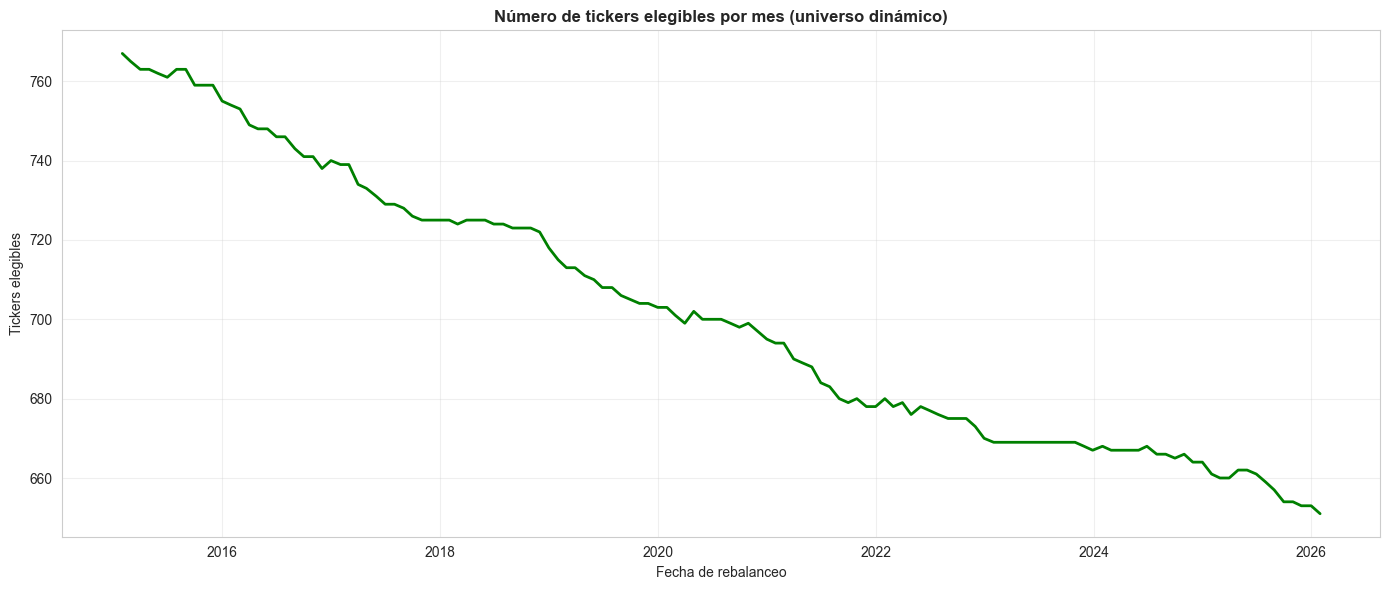

Tickers elegibles alguna vez: 832


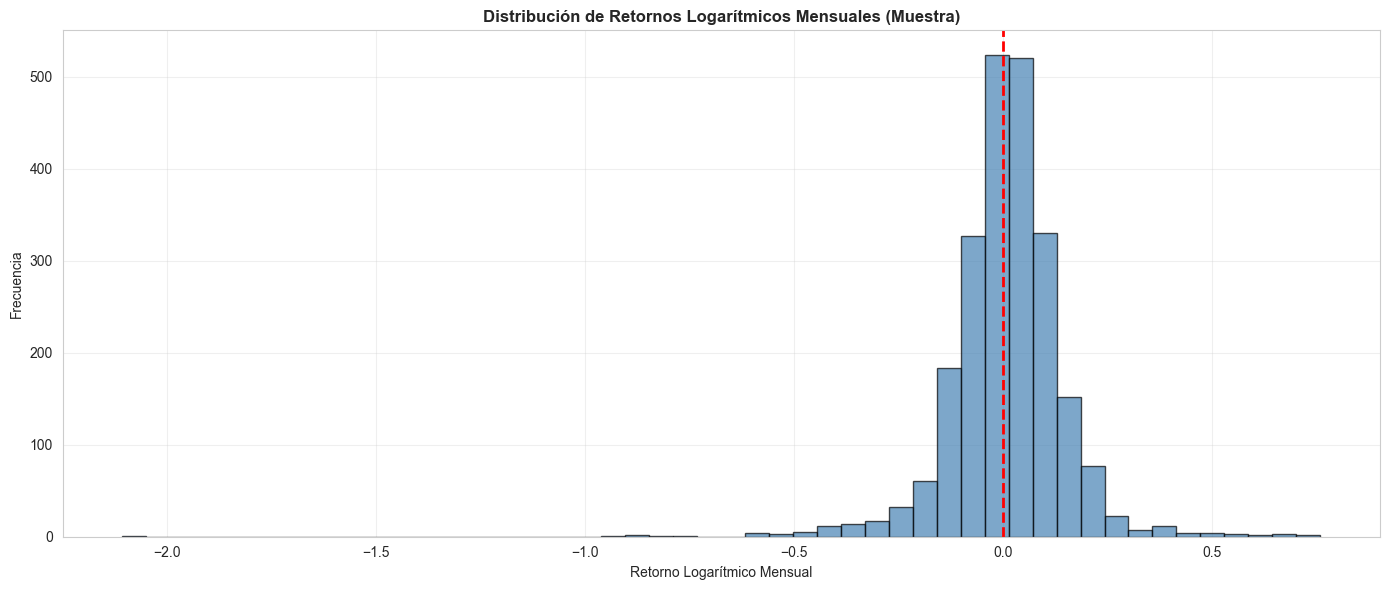

In [ ]:
### 5.2. Funcion de Elegibilidad

def build_eligibility_mask(monthly_prices: pd.DataFrame,
                           rebalance_dates: pd.DatetimeIndex,
                           min_months_history: int = 13,
                           lag_months: int = 1) -> pd.DataFrame:
    """Eligibility mask for momentum windows on rebalance dates.

    Eligibility at date t requires availability of month-end prices at:
    - t-lag, t-lag-6, t-lag-12

    CRITICAL: Only uses data from t-13 to t-1 (never t or future).

    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Business-month-end prices.
    rebalance_dates : pd.DatetimeIndex
        Rebalance dates (subset of monthly_prices.index).
    min_months_history : int
        Months needed for 12M momentum with lag=1 (typically 13).
    lag_months : int
        Lag in months (typically 1).

    Returns
    -------
    pd.DataFrame
        Boolean mask indexed by rebalance_dates, columns tickers.
    """
    eligibility = pd.DataFrame(False, index=rebalance_dates,
                              columns=monthly_prices.columns)
    min_pos = min_months_history + lag_months - 1

    for date in rebalance_dates:
        pos = monthly_prices.index.get_loc(date)
        if pos < min_pos:
            continue

        p_t1 = monthly_prices.iloc[pos - lag_months]
        p_t7 = monthly_prices.iloc[pos - (lag_months + 6)]
        p_t13 = monthly_prices.iloc[pos - (lag_months + 12)]

        elig = (p_t1.notna() & p_t7.notna() & p_t13.notna() &
                (p_t1 > 0) & (p_t7 > 0) & (p_t13 > 0))
        eligibility.loc[date] = elig

    return eligibility


eligibility_mask = build_eligibility_mask(
    monthly_prices=prices_monthly_close,
    rebalance_dates=rebalance_dates,
    min_months_history=MIN_MONTHS_HISTORY,
    lag_months=1
)

eligible_counts = eligibility_mask.sum(axis=1)
print(f'Elegibilidad: {int(eligible_counts.min())}-{int(eligible_counts.max())} tickers por mes')

eligible_from = pd.Series(pd.NaT, index=eligibility_mask.columns,
                         dtype='datetime64[ns]')
for ticker in eligibility_mask.columns:
    mask = eligibility_mask[ticker].to_numpy()
    if mask.any():
        eligible_from.loc[ticker] = eligibility_mask.index[int(mask.argmax())]

print(f'Tickers elegibles alguna vez: {int(eligible_from.notna().sum())}')

### 5.3. Validaciones de Look-Ahead Bias

In [ ]:
def test_lookahead_bias(monthly_prices: pd.DataFrame,
                        eligibility_mask: pd.DataFrame,
                        lag_months: int = 1) -> bool:
    """Test that eligibility only uses past data (no look-ahead bias).

    Parameters
    ----------
    monthly_prices : pd.DataFrame
        Monthly prices.
    eligibility_mask : pd.DataFrame
        Eligibility mask to test.
    lag_months : int
        Lag in months.

    Returns
    -------
    bool
        True if no look-ahead bias detected.
    """
    for date in eligibility_mask.index:
        pos = monthly_prices.index.get_loc(date)
        if pos < 13:
            continue

        eligible_tickers = eligibility_mask.loc[date]
        eligible_tickers = eligible_tickers[eligible_tickers].index

        for ticker in eligible_tickers:
            p_t = monthly_prices.loc[date, ticker]
            p_t1 = monthly_prices.iloc[pos - lag_months][ticker]
            p_t7 = monthly_prices.iloc[pos - (lag_months + 6)][ticker]
            p_t13 = monthly_prices.iloc[pos - (lag_months + 12)][ticker]

            if pd.isna(p_t1) or pd.isna(p_t7) or pd.isna(p_t13):
                return False

            if p_t1 <= 0 or p_t7 <= 0 or p_t13 <= 0:
                return False

    return True


lookahead_test = test_lookahead_bias(prices_monthly_close, eligibility_mask)
print(f'Test de look-ahead bias: {"PASADO" if lookahead_test else "FALLIDO"}')

sample_date = rebalance_dates[10]
sample_pos = prices_monthly_close.index.get_loc(sample_date)
print(f'\nEjemplo de calculo de elegibilidad para {sample_date.date()}:')
print(f'  Posicion en indice: {sample_pos}')
print(f'  Precio en t-1 (pos {sample_pos - 1}): {prices_monthly_close.index[sample_pos - 1].date()}')
print(f'  Precio en t-7 (pos {sample_pos - 7}): {prices_monthly_close.index[sample_pos - 7].date()}')
print(f'  Precio en t-13 (pos {sample_pos - 13}): {prices_monthly_close.index[sample_pos - 13].date()}')
print(f'  Precio en t (pos {sample_pos}): {sample_date.date()} - NO USADO')

### 5.4. Visualizaciones de Elegibilidad

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(eligible_counts.index, eligible_counts.values, color='green',
        linewidth=2)
ax.set_title('Serie temporal de numero de tickers elegibles por mes',
             fontweight='bold')
ax.set_xlabel('Fecha de rebalanceo')
ax.set_ylabel('Tickers elegibles')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
ax.hist(eligible_from.dropna(), bins=60, color='steelblue', alpha=0.75,
        edgecolor='black')
ax.axvline(backtest_start, color='red', linestyle='--', linewidth=2,
           label=f'BACKTEST_START_DATE ({backtest_start.date()})')
ax.set_title('Distribucion de fecha de primera elegibilidad (eligible_from)',
             fontweight='bold')
ax.set_xlabel('Fecha de primera elegibilidad')
ax.set_ylabel('Numero de tickers')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

sample_tickers_elig = eligibility_mask.columns[:15]
sample_dates_elig = eligibility_mask.index[::10]

eligibility_sample = eligibility_mask.loc[sample_dates_elig, sample_tickers_elig]

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(eligibility_sample.T, ax=ax, cmap='RdYlGn',
            cbar_kws={'label': 'Elegible'}, xticklabels=10, yticklabels=True)
ax.set_title('Heatmap de elegibilidad (muestra de tickers y fechas)',
             fontweight='bold')
ax.set_xlabel('Fecha de rebalanceo')
ax.set_ylabel('Ticker')
plt.tight_layout()
plt.show()

late_entrants = eligible_from[eligible_from > backtest_start].dropna()
print(f'Tickers que se vuelven elegibles despues del primer rebalanceo: {len(late_entrants)}')
if len(late_entrants) > 0:
    print(f'  Primera entrada tardia: {late_entrants.min().date()}')
    print(f'  Ultima entrada tardia: {late_entrants.max().date()}')

## 6. Analisis de Sesgo de Supervivencia

### 6.1. Sesgo de Supervivencia en el Dataset

El sesgo de supervivencia ocurre cuando solo se consideran activos que sobreviven hasta el final del periodo de analisis, excluyendo aquellos que fueron delisted durante el periodo. Esto puede inflar artificialmente los retornos porque se ignoran los activos que tuvieron mal desempeno y fueron eliminados del indice.

**Medidas de mitigacion**:
- **Universo dinamico**: Permite que nuevos activos entren al universo cuando acumulen suficiente historico, y que activos delisted salgan cuando dejen de cotizar.

**Limitaciones**:
- No se puede eliminar completamente sin datos historicos de delistings reales.
- Solo consideramos tickers que sobreviven hasta el final del dataset.
- No tenemos informacion sobre el rendimiento de tickers delisted antes de su delisting.

Analizando gaps consecutivos...
Gaps: media=2.20, p95=7.00, max=651 días


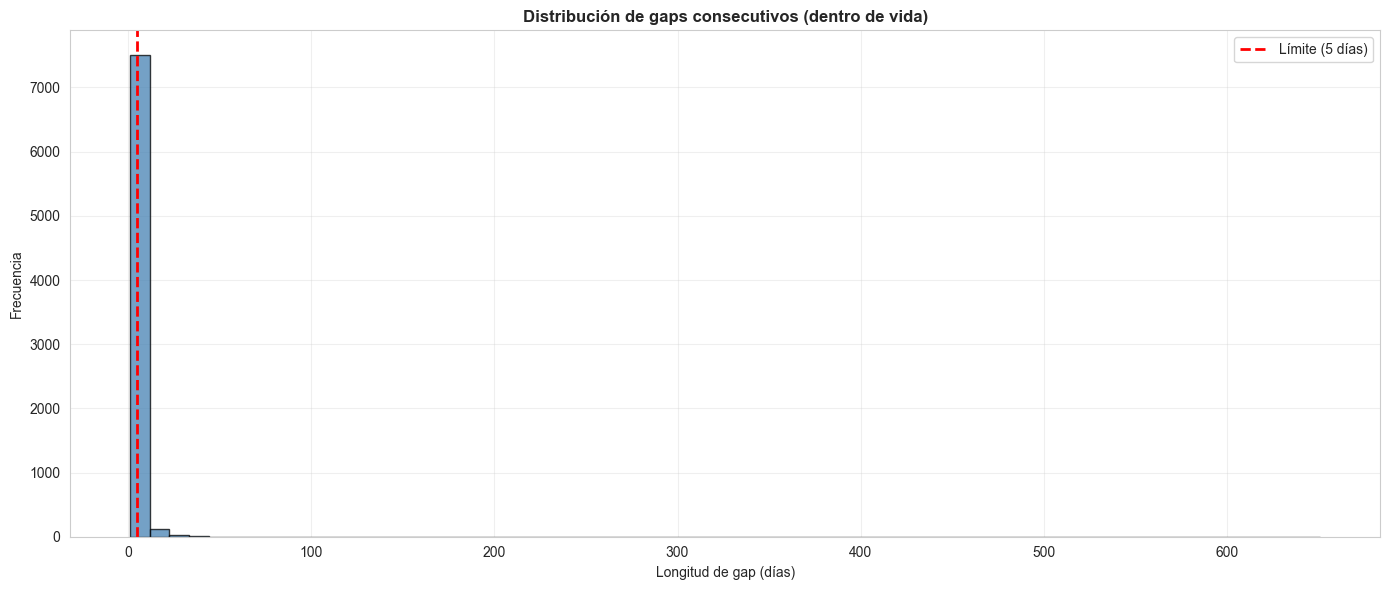


Aplicando forward fill...
CLOSE: 16,868 -> 3,692 (78.1% reducción)
OPEN: 16,868 -> 3,692 (78.1% reducción)


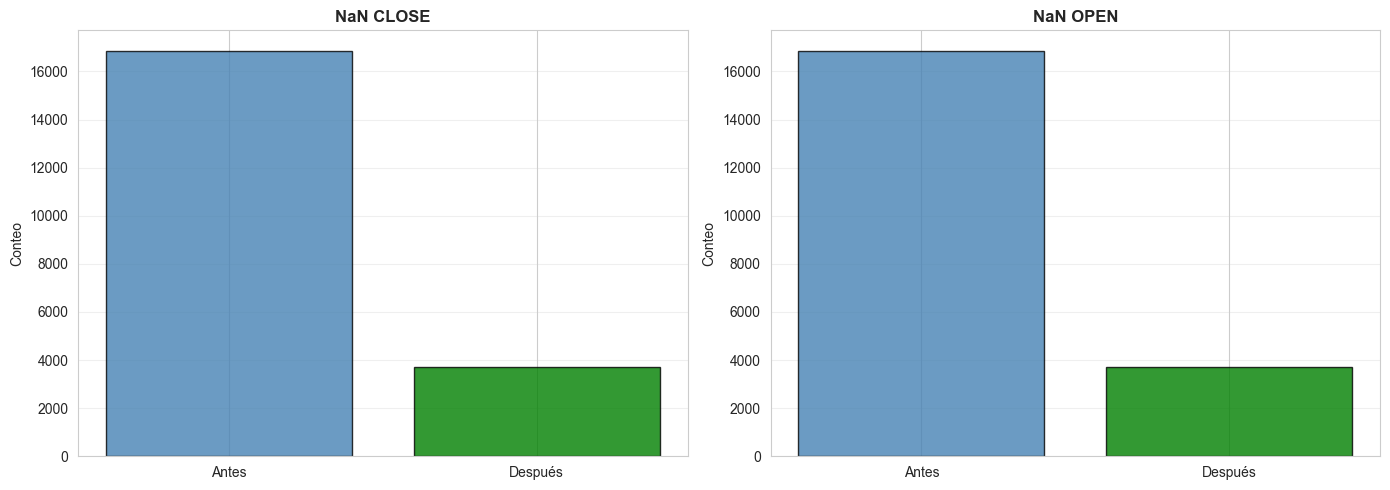

In [ ]:
### 6.2. Identificacion de Delistings

def identify_delistings(last: pd.Series,
                       dataset_end: pd.Timestamp,
                       min_days_to_end: int = 30) -> pd.DataFrame:
    """Identify possible delistings based on last valid date.

    Parameters
    ----------
    last : pd.Series
        Last valid date per ticker.
    dataset_end : pd.Timestamp
        End date of the dataset.
    min_days_to_end : int
        Minimum calendar days between last_date and dataset_end.

    Returns
    -------
    pd.DataFrame
        Table with delisting diagnostics.
    """
    df = pd.DataFrame({'last_date': last}).copy()
    df['days_to_end'] = (dataset_end - df['last_date']).dt.days
    df['delisted'] = df['days_to_end'] >= min_days_to_end
    df.loc[df['last_date'].isna(), 'delisted'] = False
    return df


delisting_diag = identify_delistings(
    last=dates_df['last_date'],
    dataset_end=data_end,
    min_days_to_end=30
)

dates_df['days_to_end'] = delisting_diag['days_to_end']
dates_df['delisted'] = delisting_diag['delisted']

n_delisted = int(dates_df['delisted'].sum())
print(f'Tickers marcados como delisted: {n_delisted}')

delist_by_year = dates_df.loc[dates_df['delisted'], 'last_date'].dt.year.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(delist_by_year.index, delist_by_year.values,
       color='coral', alpha=0.8, edgecolor='black')
ax.set_title('Conteo de delistings por ano (segun last_date)',
             fontweight='bold')
ax.set_xlabel('Ano (last_date)')
ax.set_ylabel('Numero de tickers')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

delisted_last = dates_df.loc[dates_df['delisted'], 'last_date'].dropna()

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(delisted_last, [1] * len(delisted_last), alpha=0.5, s=20)
ax.set_title('Timeline de delistings (scatter plot con fecha de ultimo dato)',
             fontweight='bold')
ax.set_xlabel('Fecha de ultimo dato')
ax.set_ylabel('Ticker')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nPorcentaje de tickers delisted por ano:')
for year in sorted(delist_by_year.index):
    total_in_year = (dates_df['last_date'].dt.year == year).sum()
    delisted_in_year = delist_by_year[year]
    pct = (delisted_in_year / total_in_year * 100) if total_in_year > 0 else 0
    print(f'  {year}: {delisted_in_year}/{total_in_year} ({pct:.1f}%)')
    

### 6.3. Analisis de Impacto del Sesgo

In [ ]:
never_eligible = dates_df[~dates_df.index.isin(eligible_from[eligible_from.notna()].index)]
ever_eligible_tickers = dates_df[dates_df.index.isin(eligible_from[eligible_from.notna()].index)]

print(f'Tickers nunca elegibles: {len(never_eligible)}')
print(f'Tickers alguna vez elegibles: {len(ever_eligible_tickers)}')
print(f'Tickers delisted: {dates_df["delisted"].sum()}')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(['Nunca elegibles', 'Alguna vez elegibles'],
            [len(never_eligible), len(ever_eligible_tickers)],
            color=['coral', 'steelblue'], alpha=0.8, edgecolor='black')
axes[0].set_title('Comparacion de tickers nunca elegibles vs elegibles',
                  fontweight='bold')
axes[0].set_ylabel('Numero de tickers')
axes[0].grid(True, alpha=0.3, axis='y')

delisted_eligible = dates_df[(dates_df['delisted']) &
                              (dates_df.index.isin(eligible_from[eligible_from.notna()].index))]
delisted_never_eligible = dates_df[(dates_df['delisted']) &
                                   (~dates_df.index.isin(eligible_from[eligible_from.notna()].index))]

axes[1].bar(['Delisted y elegibles', 'Delisted nunca elegibles'],
            [len(delisted_eligible), len(delisted_never_eligible)],
            color=['darkgreen', 'darkred'], alpha=0.8, edgecolor='black')
axes[1].set_title('Analisis de tickers delisted', fontweight='bold')
axes[1].set_ylabel('Numero de tickers')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'\nLimitaciones del analisis:')
print(f'  - No tenemos datos de rendimiento de tickers antes de delisting')
print(f'  - No podemos comparar rendimiento de sobrevivientes vs delisted')
print(f'  - El sesgo de supervivencia puede inflar retornos estimados')

### 6.4. Visualizaciones de Sesgo de Supervivencia

## 7. Politica de Imputacion (Forward Fill)

### 7.1. Forward Fill y Control de Sesgos

El forward fill se aplica con un limite de 5 dias consecutivos para suavizar faltantes puntuales sin introducir sesgos significativos:

- **Por que forward fill con limite de 5 dias**: La mayoria de gaps son pequenos (media 2.2 dias, p95 7 dias). Un limite de 5 dias cubre la mayoria de gaps sin extender artificialmente la vida de activos.

- **Por que NO se usa para construir elegibilidad**: La elegibilidad se basa en precios mensuales reales, no en precios imputados. Esto evita "inventar" historia que no existio.

- **Control de extension de vida**: El forward fill solo se aplica dentro de la vida del activo (entre first_date y last_date), no extiende la vida mas alla de last_date.

**Impacto en sesgos**: El forward fill puede introducir sesgo si se usa incorrectamente, pero con el limite de 5 dias y solo para gaps pequenos, el impacto es minimo.

### 7.2. Funcion de Forward Fill

In [ ]:
def forward_fill_within_life(prices: pd.DataFrame,
                             first: pd.Series,
                             last: pd.Series,
                             limit: int) -> pd.DataFrame:
    """Forward-fill only within each asset's life.

    Parameters
    ----------
    prices : pd.DataFrame
        Daily prices.
    first : pd.Series
        First valid date per ticker.
    last : pd.Series
        Last valid date per ticker.
    limit : int
        Maximum consecutive days to forward-fill.

    Returns
    -------
    pd.DataFrame
        Forward-filled prices within life.
    """
    filled = prices.copy()
    max_date = prices.index.max()

    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            filled[ticker] = np.nan
            continue

        filled.loc[f:l, ticker] = prices.loc[f:l, ticker].ffill(limit=limit)
        if l < max_date:
            filled.loc[prices.index > l, ticker] = np.nan

    return filled


def gap_lengths_within_life(prices: pd.DataFrame,
                            first: pd.Series,
                            last: pd.Series) -> np.ndarray:
    """Collect consecutive NaN gap lengths within each asset's life."""
    lengths = []
    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            continue

        s = prices.loc[f:l, ticker]
        is_na = s.isna().to_numpy()
        current = 0
        for val in is_na:
            if val:
                current += 1
            else:
                if current > 0:
                    lengths.append(current)
                    current = 0
        if current > 0:
            lengths.append(current)
    return np.array(lengths, dtype='int64')


def nan_count_within_life(prices: pd.DataFrame,
                          first: pd.Series,
                          last: pd.Series) -> int:
    """Total NaN count within life across all tickers."""
    total = 0
    for ticker in prices.columns:
        f = first.get(ticker)
        l = last.get(ticker)
        if pd.isna(f) or pd.isna(l):
            continue
        total += int(prices.loc[f:l, ticker].isna().sum())
    return total

### 7.3. Analisis de Gaps

In [ ]:
print('Analizando gaps consecutivos...')
gap_lengths = gap_lengths_within_life(prices_close_wide, dates_df['first_date'],
                                      dates_df['last_date'])

if len(gap_lengths) == 0:
    raise ValueError('No se pudieron calcular gaps dentro de vida.')

print(f'Gaps: media={gap_lengths.mean():.2f}, '
      f'p95={np.percentile(gap_lengths, 95):.2f}, '
      f'max={gap_lengths.max()} dias')

fig, ax = plt.subplots(figsize=(14, 6))
bins = int(min(60, gap_lengths.max()))
ax.hist(gap_lengths, bins=bins, color='steelblue', alpha=0.75,
        edgecolor='black')
ax.axvline(FFILL_GAP_LIMIT_DAYS, color='red', linestyle='--', linewidth=2,
           label=f'Limite ({FFILL_GAP_LIMIT_DAYS} dias)')
ax.set_title('Distribucion de gaps consecutivos (dentro de vida)',
             fontweight='bold')
ax.set_xlabel('Longitud de gap (dias)')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print(f'\nJustificacion del limite de {FFILL_GAP_LIMIT_DAYS} dias:')
print(f'  - Media de gaps: {gap_lengths.mean():.2f} dias')
print(f'  - Percentil 95: {np.percentile(gap_lengths, 95):.2f} dias')
print(f'  - El limite cubre la mayoria de gaps sin extender vida artificialmente')

### 7.4. Visualizaciones

In [ ]:
print('\nAplicando forward fill...')
missing_before_close = nan_count_within_life(prices_close_wide,
                                              dates_df['first_date'],
                                              dates_df['last_date'])
missing_before_open = nan_count_within_life(prices_open_wide,
                                            dates_df['first_date'],
                                            dates_df['last_date'])

prices_close_ffill = forward_fill_within_life(prices_close_wide,
                                              dates_df['first_date'],
                                              dates_df['last_date'],
                                              FFILL_GAP_LIMIT_DAYS)
prices_open_ffill = forward_fill_within_life(prices_open_wide,
                                             dates_df['first_date'],
                                             dates_df['last_date'],
                                             FFILL_GAP_LIMIT_DAYS)

missing_after_close = nan_count_within_life(prices_close_ffill,
                                            dates_df['first_date'],
                                            dates_df['last_date'])
missing_after_open = nan_count_within_life(prices_open_ffill,
                                          dates_df['first_date'],
                                          dates_df['last_date'])

reduction_close_pct = ((missing_before_close - missing_after_close) /
                       missing_before_close * 100) if missing_before_close > 0 else 0
reduction_open_pct = ((missing_before_open - missing_after_open) /
                      missing_before_open * 100) if missing_before_open > 0 else 0

print(f'CLOSE: {missing_before_close:,} -> {missing_after_close:,} '
      f'({reduction_close_pct:.1f}% reduccion)')
print(f'OPEN: {missing_before_open:,} -> {missing_after_open:,} '
      f'({reduction_open_pct:.1f}% reduccion)')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(['Antes', 'Despues'], [missing_before_close, missing_after_close],
            color=['steelblue', 'green'], alpha=0.8, edgecolor='black')
axes[0].set_title('NaN CLOSE', fontweight='bold')
axes[0].set_ylabel('Conteo')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(['Antes', 'Despues'], [missing_before_open, missing_after_open],
            color=['steelblue', 'green'], alpha=0.8, edgecolor='black')
axes[1].set_title('NaN OPEN', fontweight='bold')
axes[1].set_ylabel('Conteo')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

completitud_before = (1 - missing_before_close / 
                     (prices_close_wide.notna().sum().sum())) * 100
completitud_after = (1 - missing_after_close / 
                    (prices_close_ffill.notna().sum().sum())) * 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.boxplot([completitud_before, completitud_after],
           labels=['Antes', 'Despues'], patch_artist=True,
           boxprops=dict(facecolor='steelblue', alpha=0.7))
ax.set_title('Comparacion antes/despues de forward fill (completitud)',
             fontweight='bold')
ax.set_ylabel('Completitud (%)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 8. Procesamiento de SPY (Benchmark)

### 8.1. Procesamiento de Benchmark

SPY (S&P 500 ETF) se procesa siguiendo el mismo proceso que los tickers individuales para mantener consistencia:

- **Mismo proceso**: Forward fill con limite de 5 dias, agregacion mensual, calculo de retornos.

- **Importancia de alineacion temporal**: SPY debe estar alineado con `rebalance_dates` para comparaciones correctas en el analisis posterior.

- **Uso en analisis posterior**: SPY se usa como benchmark en el Notebook 5 para comparar rendimiento de la estrategia.


Procesando SPY...
SPY: 2798 días, 134 meses, 0 faltantes en rebalanceo


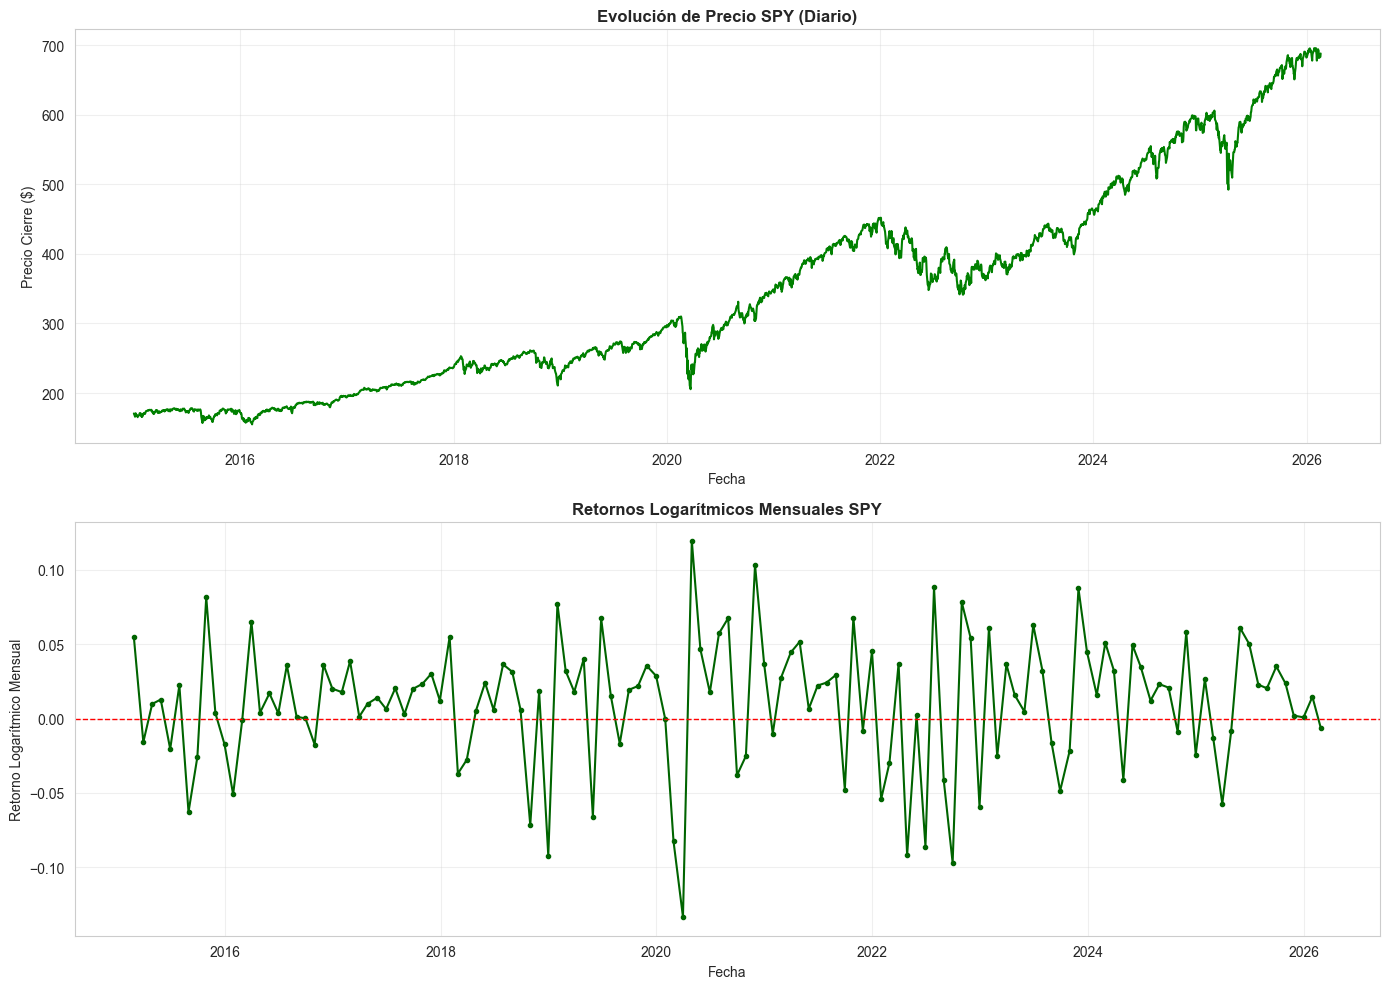

In [ ]:
### 8.2. Procesamiento de SPY

spy_required = {'open', 'close'}
if spy_required - set(spy_df.columns):
    raise ValueError(f'SPY falta columnas: {sorted(spy_required - set(spy_df.columns))}')

spy_clean = pd.DataFrame({
    'open': spy_df['open'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'close': spy_df['close'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'high': spy_df['high'].ffill(limit=FFILL_GAP_LIMIT_DAYS),
    'low': spy_df['low'].ffill(limit=FFILL_GAP_LIMIT_DAYS)
}, index=spy_df.index)

spy_clean = spy_clean.loc[spy_clean.index >= history_start].copy()

spy_log_returns_daily = calculate_log_returns(spy_clean[['close']])
spy_log_returns_daily.columns = ['SPY']

spy_prices_monthly = build_monthly_prices(spy_clean[['close']])
spy_prices_monthly.columns = ['SPY']
spy_log_returns_monthly = calculate_log_returns(spy_prices_monthly)
spy_log_returns_monthly.columns = ['SPY']

missing_spy = spy_prices_monthly.reindex(rebalance_dates)['SPY'].isna().sum()
print(f'SPY procesado: {spy_clean.shape[0]} dias, {spy_prices_monthly.shape[0]} meses')
print(f'Faltantes en rebalanceo: {missing_spy}')

assert all(date in spy_prices_monthly.index for date in rebalance_dates), \
    'SPY debe estar alineado con rebalance_dates'

### 8.3. Visualizaciones de SPY

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(spy_clean.index, spy_clean['close'], color='green', linewidth=1.5)
axes[0].set_title('Evolucion de Precio SPY (Diario)', fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Precio Cierre ($)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(spy_prices_monthly.index, spy_prices_monthly['SPY'],
             color='darkgreen', linewidth=2, marker='o', markersize=4)
axes[1].set_title('Evolucion de Precio SPY (Mensual)', fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Precio Mensual ($)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(spy_log_returns_monthly.index, spy_log_returns_monthly['SPY'],
        color='darkgreen', linewidth=1.5, marker='o', markersize=3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.set_title('Retornos Logaritmicos Mensuales SPY', fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Retorno Logaritmico Mensual')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

spy_completitud = spy_clean['close'].notna().mean() * 100
universe_completitud = prices_close_wide.notna().mean().mean() * 100

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(['SPY', 'Universo principal'],
       [spy_completitud, universe_completitud],
       color=['darkgreen', 'steelblue'], alpha=0.8, edgecolor='black')
ax.set_title('Comparacion de completitud SPY vs universo principal',
             fontweight='bold')
ax.set_ylabel('Completitud (%)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 9. Construccion de Metadata

### 9.1. Metadata y Trazabilidad

La metadata contiene informacion esencial sobre cada ticker para trazabilidad y analisis posterior:

- **Campos criticos**: first_date, last_date, delisted, pct_missing_within_life, eligible_from, ever_eligible.

- **Importancia de trazabilidad**: Permite entender por que un ticker fue incluido o excluido, y cuando se volvio elegible.

- **Campos para control de sesgos**: delisted y eligible_from ayudan a documentar el impacto del sesgo de supervivencia.

### 9.2. Construccion de Metadata

In [ ]:
log_returns_daily = calculate_log_returns(prices_close_wide)

prices_close_final = prices_close_ffill.loc[prices_close_ffill.index >= history_start].copy()
prices_open_final = prices_open_ffill.loc[prices_open_ffill.index >= history_start].copy()
log_returns_final = calculate_log_returns(prices_close_final)

metadata = pd.DataFrame({
    'first_date': dates_df['first_date'],
    'last_date': dates_df['last_date'],
    'delisted': dates_df['delisted'].fillna(False),
    'pct_missing_within_life': dates_df['pct_missing_within_life'],
    'eligible_from': eligible_from,
    'ever_eligible': eligible_from.notna(),
    'reason_excluded': None
})

print(f'Metadata construida: {len(metadata)} tickers')
print(f'  - Elegibles alguna vez: {metadata["ever_eligible"].sum()}')
print(f'  - Delisted: {metadata["delisted"].sum()}')

### 9.3. Validaciones de Metadata

In [ ]:
assert len(metadata) == len(prices_close_wide.columns), \
    'Todos los tickers deben tener metadata'

assert metadata['first_date'].notna().all(), \
    'Todos los tickers deben tener first_date'

assert (metadata['eligible_from'].notna() == metadata['ever_eligible']).all(), \
    'Consistencia entre eligible_from y ever_eligible'

assert (metadata['eligible_from'].dropna() >= backtest_start).all() or \
       metadata['eligible_from'].dropna().empty, \
    'eligible_from debe ser >= backtest_start o NaT'

print('Validaciones de metadata: OK')

## 10. Validaciones Finales y Control de Calidad

### 10.1. Validaciones Criticas

Las siguientes validaciones son criticas para asegurar la integridad del dataset y el control de sesgos:

- **Sin look-ahead bias**: Verificar que elegibilidad y momentum solo usan datos pasados.

- **Control de sesgo de supervivencia**: Documentar tickers delisted y nunca elegibles.

- **Integridad de datos**: Sin infinitos, precios positivos, OPEN/CLOSE disponibles en rebalanceo.

- **Calidad de datos**: Completitud minima aceptable, gaps manejados correctamente.

### 10.2. Checklist de Validaciones

In [ ]:
print('Validaciones finales...\n')

validation_results = {}

validation_results['lookahead_bias'] = test_lookahead_bias(
    prices_monthly_close, eligibility_mask
)
print(f'1. Sin look-ahead bias: {"OK" if validation_results["lookahead_bias"] else "ERROR"}')

validation_results['eligibility_past_only'] = True
for date in rebalance_dates[:5]:
    pos = prices_monthly_close.index.get_loc(date)
    if pos >= 13:
        eligible_tickers = eligibility_mask.loc[date][eligibility_mask.loc[date]].index
        for ticker in eligible_tickers[:3]:
            p_t = prices_monthly_close.loc[date, ticker]
            p_t1 = prices_monthly_close.iloc[pos - 1][ticker]
            if pd.isna(p_t1):
                validation_results['eligibility_past_only'] = False
                break
print(f'2. Elegibilidad solo usa datos pasados: {"OK" if validation_results["eligibility_past_only"] else "ERROR"}')

validation_results['delistings_documented'] = metadata['delisted'].sum() > 0
print(f'3. Delistings documentados: {"OK" if validation_results["delistings_documented"] else "WARNING"}')

validation_results['never_eligible_documented'] = (~metadata['ever_eligible']).sum() > 0
print(f'4. Tickers nunca elegibles documentados: {"OK" if validation_results["never_eligible_documented"] else "WARNING"}')

survival_stats = {
    'total_tickers': len(metadata),
    'ever_eligible': metadata['ever_eligible'].sum(),
    'delisted': metadata['delisted'].sum(),
    'survival_rate': (metadata['ever_eligible'].sum() / len(metadata) * 100)
}
print(f'5. Estadisticas de supervivencia:')
print(f'   - Total tickers: {survival_stats["total_tickers"]}')
print(f'   - Tickers elegibles: {survival_stats["ever_eligible"]} ({survival_stats["survival_rate"]:.1f}%)')
print(f'   - Tickers delisted: {survival_stats["delisted"]}')

validation_results['no_inf_daily'] = not np.isinf(log_returns_final).any().any()
validation_results['no_inf_monthly'] = not np.isinf(log_returns_monthly).any().any()
print(f'6. Sin infinitos diarios: {"OK" if validation_results["no_inf_daily"] else "ERROR"}')
print(f'7. Sin infinitos mensuales: {"OK" if validation_results["no_inf_monthly"] else "ERROR"}')

validation_results['positive_prices'] = (
    (prices_close_final > 0).all().all() and
    (prices_open_final > 0).all().all()
)
print(f'8. Precios positivos: {"OK" if validation_results["positive_prices"] else "ERROR"}')

open_missing_rebalance = prices_open_final.reindex(rebalance_dates).isna().sum().sum()
close_missing_rebalance = prices_close_final.reindex(rebalance_dates).isna().sum().sum()
validation_results['open_close_rebalance'] = (
    open_missing_rebalance == 0 and close_missing_rebalance == 0
)
print(f'9. OPEN/CLOSE en rebalanceo: {"OK" if validation_results["open_close_rebalance"] else "ERROR"}')
if not validation_results['open_close_rebalance']:
    print(f'   - OPEN faltantes: {open_missing_rebalance}')
    print(f'   - CLOSE faltantes: {close_missing_rebalance}')

validation_results['spy_aligned'] = (
    spy_prices_monthly.reindex(rebalance_dates)['SPY'].isna().sum() == 0
)
print(f'10. SPY alineado con rebalance_dates: {"OK" if validation_results["spy_aligned"] else "ERROR"}')

validation_results['indices_consistent'] = (
    prices_close_final.index.equals(prices_open_final.index) and
    prices_close_final.index.equals(log_returns_final.index)
)
print(f'11. Indices temporales consistentes: {"OK" if validation_results["indices_consistent"] else "ERROR"}')

min_completitud = 90.0
low_quality = (metadata['pct_missing_within_life'] > (100 - min_completitud)).sum()
validation_results['min_completitud'] = low_quality < len(metadata) * 0.1
print(f'12. Completitud minima aceptable: {"OK" if validation_results["min_completitud"] else "WARNING"}')
print(f'    - Tickers con < {min_completitud}% completitud: {low_quality}')

all_critical_ok = all([
    validation_results['lookahead_bias'],
    validation_results['eligibility_past_only'],
    validation_results['no_inf_daily'],
    validation_results['no_inf_monthly'],
    validation_results['positive_prices'],
    validation_results['spy_aligned'],
    validation_results['indices_consistent']
])

print(f'\nValidaciones criticas: {"TODAS PASADAS" if all_critical_ok else "ALGUNAS FALLIDAS"}')

### 10.3. Visualizaciones de Validacion

In [ ]:
validation_summary = pd.DataFrame({
    'Validacion': [
        'Look-ahead bias',
        'Elegibilidad datos pasados',
        'Delistings documentados',
        'Nunca elegibles documentados',
        'Sin infinitos diarios',
        'Sin infinitos mensuales',
        'Precios positivos',
        'OPEN/CLOSE en rebalanceo',
        'SPY alineado',
        'Indices consistentes',
        'Completitud minima'
    ],
    'Estado': [
        'OK' if validation_results['lookahead_bias'] else 'ERROR',
        'OK' if validation_results['eligibility_past_only'] else 'ERROR',
        'OK' if validation_results['delistings_documented'] else 'WARNING',
        'OK' if validation_results['never_eligible_documented'] else 'WARNING',
        'OK' if validation_results['no_inf_daily'] else 'ERROR',
        'OK' if validation_results['no_inf_monthly'] else 'ERROR',
        'OK' if validation_results['positive_prices'] else 'ERROR',
        'OK' if validation_results['open_close_rebalance'] else 'ERROR',
        'OK' if validation_results['spy_aligned'] else 'ERROR',
        'OK' if validation_results['indices_consistent'] else 'ERROR',
        'OK' if validation_results['min_completitud'] else 'WARNING'
    ]
})

fig, ax = plt.subplots(figsize=(14, 8))
colors = ['green' if s == 'OK' else 'red' if s == 'ERROR' else 'orange'
          for s in validation_summary['Estado']]
ax.barh(validation_summary['Validacion'], [1] * len(validation_summary),
        color=colors, alpha=0.7, edgecolor='black')
ax.set_title('Resumen de Validaciones', fontweight='bold')
ax.set_xlabel('Estado')
ax.set_xticks([])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 6))
completitud_final = (100 - metadata['pct_missing_within_life']).dropna()
ax.hist(completitud_final, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(90, color='red', linestyle='--', linewidth=2, label='Minimo 90%')
ax.set_title('Distribucion de completitud final', fontweight='bold')
ax.set_xlabel('Completitud (%)')
ax.set_ylabel('Numero de tickers')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

excluded = metadata[metadata['reason_excluded'].notna()]
if len(excluded) > 0:
    print(f'\nTickers excluidos: {len(excluded)}')
    print(excluded[['first_date', 'last_date', 'pct_missing_within_life', 'reason_excluded']].head(10))

## 11. Guardado de Datasets

### 11.1. Archivos Generados y su Uso

Los siguientes archivos se generan para uso en notebooks posteriores:

- **Notebook 3 (Implementacion Estrategia)**: clean_data.parquet, prices_monthly.parquet, log_returns_monthly.parquet, eligibility_mask.parquet, rebalance_dates.csv, ticker_metadata.csv

- **Notebook 4 (Ejecucion Costes)**: prices_open_daily.parquet, prices_open_monthly.parquet, log_returns.parquet, rebalance_dates.csv, ticker_metadata.csv

- **Notebook 5 (Comparativa Metricas)**: ticker_metadata.csv, spy_clean.parquet, spy_log_returns_daily.parquet, spy_prices_monthly.parquet, spy_log_returns_monthly.parquet

**Aliases**: Algunos archivos tienen nombres alternativos documentados pero no se guardan duplicados.

### 11.2. Guardado Optimizado

In [ ]:
files_to_save = [
    ('clean_data.parquet', prices_close_final, 'Notebook 3, 4'),
    ('prices_open_daily.parquet', prices_open_final, 'Notebook 4'),
    ('log_returns.parquet', log_returns_final, 'Notebook 3, 4'),
    ('prices_monthly.parquet', prices_monthly_close, 'Notebook 3'),
    ('prices_open_monthly.parquet', prices_monthly_open, 'Notebook 4'),
    ('log_returns_monthly.parquet', log_returns_monthly, 'Notebook 3'),
    ('ticker_metadata.csv', metadata, 'Notebook 3, 4, 5'),
    ('eligibility_mask.parquet', eligibility_mask, 'Notebook 3'),
    ('rebalance_dates.csv', pd.Series(rebalance_dates, name='rebalance_date'), 'Notebook 3, 4'),
    ('spy_clean.parquet', spy_clean, 'Notebook 5'),
    ('spy_log_returns_daily.parquet', spy_log_returns_daily, 'Notebook 5'),
    ('spy_prices_monthly.parquet', spy_prices_monthly, 'Notebook 5'),
    ('spy_log_returns_monthly.parquet', spy_log_returns_monthly, 'Notebook 5')
]

print('Guardando archivos...')
for filename, data, used_in in files_to_save:
    path = f'{DATA_PROCESSED_DIR}/{filename}'
    if filename.endswith('.csv'):
        data.to_csv(path, index=True)
    else:
        data.to_parquet(path, engine='pyarrow')
    print(f'  {filename} -> {used_in}')

aliases_doc = [
    ('prices_close_daily.parquet', 'clean_data.parquet'),
    ('prices_close_monthly.parquet', 'prices_monthly.parquet')
]
print('\nAliases documentados (no guardados, usar archivos principales):')
for alias, main_file in aliases_doc:
    print(f'  {alias} -> {main_file}')

print(f'\nArchivos guardados: {len(files_to_save)}')

Construyendo dataset final...
Metadata: 1289 tickers, 832 elegibles, 638 delisted

Validaciones finales...
  OPEN en rebalanceo: ERROR
  CLOSE en rebalanceo: ERROR
  SPY en rebalanceo: OK
  Sin infinitos diarios: OK
  Sin infinitos mensuales: OK
  Precios positivos: OK

Guardando archivos...
  clean_data.parquet
  prices_open_daily.parquet
  log_returns.parquet
  prices_monthly.parquet
  prices_open_monthly.parquet
  log_returns_monthly.parquet
  ticker_metadata.csv
  eligibility_mask.parquet
  rebalance_dates.csv
  spy_clean.parquet
  spy_log_returns_daily.parquet
  spy_prices_monthly.parquet
  spy_log_returns_monthly.parquet

Aliases (no guardados, usar archivos principales):
  prices_close_daily.parquet -> clean_data.parquet
  prices_close_monthly.parquet -> prices_monthly.parquet

Resumen: 1289 tickers, 832 elegibles, 133 rebalanceos, 13 archivos guardados
Notebook 2 completado exitosamente.


### 12.2. Resumen Final

In [ ]:
print('=== RESUMEN EJECUTIVO ===\n')

print(f'Universo:')
print(f'  - Total tickers: {len(metadata)}')
print(f'  - Tickers elegibles alguna vez: {metadata["ever_eligible"].sum()}')
print(f'  - Tickers delisted: {metadata["delisted"].sum()}')
print(f'  - Tickers nunca elegibles: {(~metadata["ever_eligible"]).sum()}')

print(f'\nPeriodo:')
print(f'  - Rango de datos: {data_start.date()} a {data_end.date()}')
print(f'  - History start: {history_start.date()}')
print(f'  - Backtest start: {backtest_start.date()}')
print(f'  - Rebalanceos: {len(rebalance_dates)} meses')

print(f'\nCalidad de datos:')
print(f'  - Completitud promedio: {(100 - metadata["pct_missing_within_life"].mean()):.2f}%')
print(f'  - Gaps reducidos: {reduction_close_pct:.1f}% (forward fill)')

print(f'\nValidaciones:')
critical_ok = sum([
    validation_results['lookahead_bias'],
    validation_results['eligibility_past_only'],
    validation_results['no_inf_daily'],
    validation_results['no_inf_monthly'],
    validation_results['positive_prices'],
    validation_results['spy_aligned'],
    validation_results['indices_consistent']
])
print(f'  - Validaciones criticas pasadas: {critical_ok}/7')

print(f'\nArchivos generados: {len(files_to_save)}')
print(f'  - Precios diarios: 3 archivos')
print(f'  - Precios mensuales: 2 archivos')
print(f'  - Retornos: 3 archivos')
print(f'  - Metadata y calendario: 2 archivos')
print(f'  - SPY: 4 archivos')

print(f'\nAdvertencias sobre limitaciones:')
print(f'  - Sesgo de supervivencia: {metadata["delisted"].sum()} tickers delisted identificados')
print(f'  - No se puede eliminar completamente sin datos historicos de delistings')
print(f'  - Los retornos pueden estar ligeramente inflados por este sesgo')

print('\nNotebook 2 completado exitosamente.')